# Humaiyon Abdullah


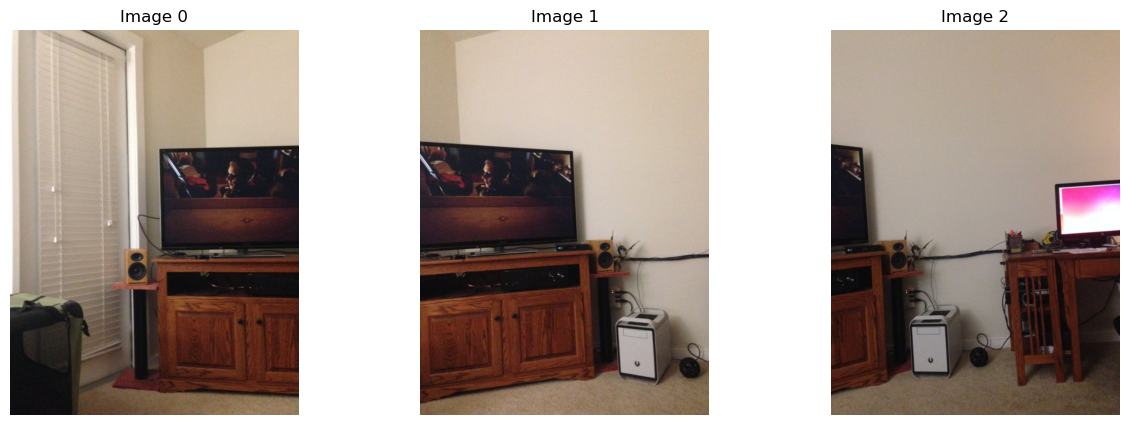

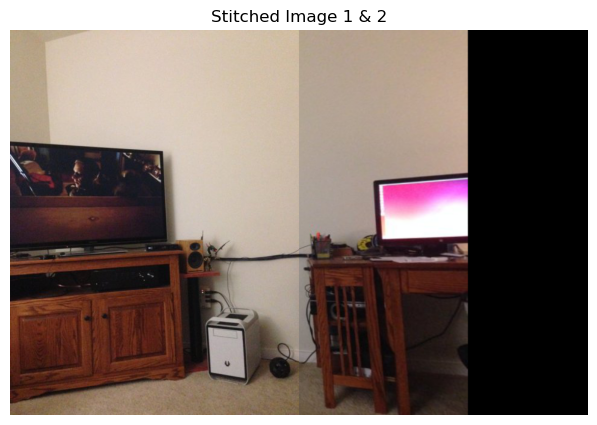

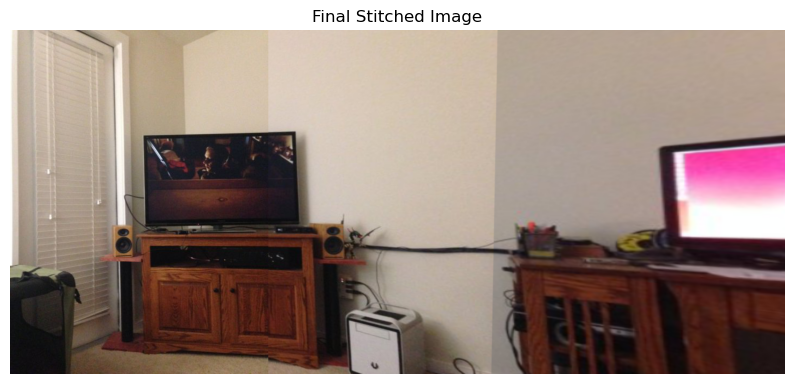

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(img1, img2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Create SIFT object
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    
    # Match keypoints
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    
    MIN_MATCH_COUNT = 10
    if len(good_matches) >= MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Estimate homography matrix
        homography, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        
        # Warp img2 to align with img1
        stitched_img = cv2.warpPerspective(img2, homography, (img1.shape[1] + img2.shape[1], img1.shape[0]))
        
        # Overlay img1 onto stitched_img
        stitched_img[0:img1.shape[0], 0:img1.shape[1]] = img1
        
        return stitched_img
    else:
        print(f"Not enough matches found ({len(good_matches)}/{MIN_MATCH_COUNT})")
        return None

# Read images
image0 = cv2.imread('stitch0.jpg')
image1 = cv2.imread('stitch1.jpg')
image2 = cv2.imread('stitch2.jpg')

# Display original images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(image0, cv2.COLOR_BGR2RGB))
axs[0].set_title("Image 0")
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axs[1].set_title("Image 1")
axs[1].axis('off')
axs[2].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axs[2].set_title("Image 2")
axs[2].axis('off')
plt.show()

# Stitch image1 and image2 first
stitched12 = stitch_images(image1, image2)
if stitched12 is not None:
    # Display stitched12 result
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(stitched12, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Stitched Image 1 & 2")
    plt.show()
    
    # Stitch the result with image0
    final_stitched = stitch_images(image0, stitched12)
    if final_stitched is not None:
        # Display the final stitched image
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(final_stitched, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Final Stitched Image")
        plt.show()
    else:
        print("Failed to stitch image0 with the previous result.")
else:
    print("Failed to stitch image1 and image2.")


# (Alpha Blending)

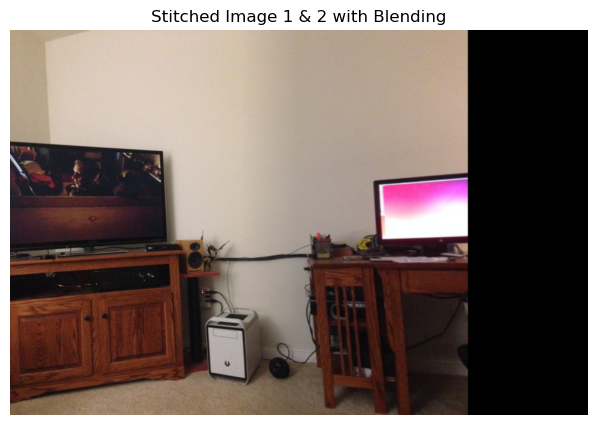

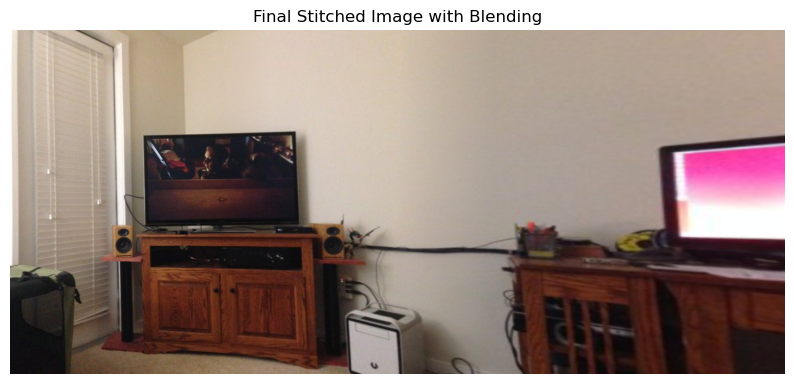

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def alpha_blend(img1, img2, mask):
    """
    Blends two images using an alpha mask.
    """
    blended = img1 * (1 - mask) + img2 * mask
    return blended.astype(np.uint8)

def stitch_images_with_blending(img1, img2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Create SIFT object
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    
    # Match keypoints
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    
    MIN_MATCH_COUNT = 10
    if len(good_matches) >= MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Estimate homography matrix
        homography, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        
        # Warp img2 to align with img1
        warped_img2 = cv2.warpPerspective(img2, homography, (img1.shape[1] + img2.shape[1], img1.shape[0]))
        
        # Create a mask for blending
        overlap_width = img1.shape[1] // 5  
        mask = np.zeros_like(warped_img2, dtype=np.float32)
        mask[:, img1.shape[1] - overlap_width : img1.shape[1], :] = np.linspace(0, 1, overlap_width)[None, :, None]

        # Blend images in the overlapping region
        blended_result = alpha_blend(img1, warped_img2[:img1.shape[0], :img1.shape[1]], mask[:img1.shape[0], :img1.shape[1]])

        # Paste the blended region onto the final image
        stitched_img = warped_img2
        stitched_img[:img1.shape[0], :img1.shape[1]] = blended_result

        return stitched_img
    else:
        print(f"Not enough matches found ({len(good_matches)}/{MIN_MATCH_COUNT})")
        return None

# Read images
image0 = cv2.imread('stitch0.jpg')
image1 = cv2.imread('stitch1.jpg')
image2 = cv2.imread('stitch2.jpg')

# Stitch image1 and image2 first with blending
stitched12 = stitch_images_with_blending(image1, image2)
if stitched12 is not None:
    # Display stitched12 result
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(stitched12, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Stitched Image 1 & 2 with Blending")
    plt.show()
    
    # Stitch the result with image0 using blending
    final_stitched = stitch_images_with_blending(image0, stitched12)
    if final_stitched is not None:
        # Display the final stitched image
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(final_stitched, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Final Stitched Image with Blending")
        plt.show()
    else:
        print("Failed to stitch image0 with the previous result.")
else:
    print("Failed to stitch image1 and image2.")
